# Multiarm Bandit

**ONE ARMED BANDIT** is a slang for a _slot machine_: It has one arm (one leaver) and it will rob you. Imagine, however, that there is not one but many such bandits. Some are worse than others, and some may even reward you. The problem, however, is that they all look the same, and we do not know how bad each one of the is. Since there are many, each with only one hand, the multitude of slot machines is referred to as **MULTIARM BANDIT**. 

<div class="alert alert-block alert-info">
<b>The Goal:</b> 
Devise a strategy for investigating the bandits (pulling the leavers and obtaining the reward/payinh the penalty) so that the total gain is maximized (total loss is minimized).
</div>

## Basic Imports

In [1]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange


## The Environment — Process Model

### Simulating one Bandit

In [2]:
class Bandit:
    """A bandit with uniform reward distribution."""

    def __init__(self, mean: float, span: float):
        """Initialize the bandit.

        Regardless of the received action, the bandit will return reward
        uniformly sampled from segment [`mean`-`span`, `mean`+`span`].

        Args:
            mean (float): Mean (expected) value of the reward.
            span (float): Span of the reward.
        """
        self.mean = mean
        self.span = span

    def pull_leaver(self) -> float:
        """Pull leaver and obtain reward.

        Returns:
            float: The obtained reward.
        """
        return self.mean + 2*self.span * (random.random()-0.5) # random number in [mean-span, mean+span]       

### Testing one Bandit

We should always test a piece of code :) This is not a formal test, but it is still a test.

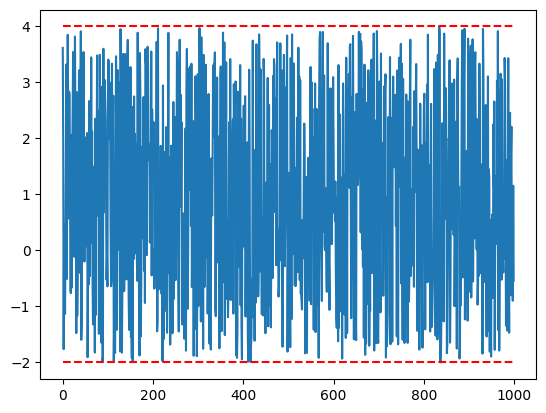

In [3]:
test_mean = 1.0
test_span = 3.0
test_len = 1000

test_bandit = Bandit(test_mean, test_span)
test_rewards = [test_bandit.pull_leaver() for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((test_mean+test_span)*np.ones(test_len), linestyle="--", color="r")
plt.plot((test_mean-test_span)*np.ones(test_len), linestyle="--", color="r")

### Building an Environment of Bandits

Now, we define an environment consisting of several bandits.

In [4]:
class BanditsEnvironment:
    """An environment consisting of multiple bandits."""

    def __init__(self, bandits: Iterable[Bandit], penalty=1000):
        """Initialize the environment.

        Args:
            bandits (iter[Bandit]): Bandits to be used within the environment.
            penalty (int, optional): 
                If the external agents attempts to use a bandit not in the list,
                i.e. if the chosen action is negative or bigger than the index of
                the last bandit, the returned reward will be `-penalty`. Defaults to 1000.
        """
        self.bandits: list[Bandit] = list(bandits)
        self.penalty = penalty

    def take_action(self, a: int):
        """
        Select bandit `a` and pull its leaver. 
        
        If the selected agent is valid, return the obtained reward.
        Otherwise, return negative penalty.
        """
        if a<0 or a>=len(self.bandits):
            return -self.penalty
        else:
            return self.bandits[a].pull_leaver()

<div class="alert alert-block alert-info">
<b>Tip:</b> 
The `Sequence` and `Iterable` **abstract base classes** (can also be used as **type annotations**) usually adhere to the following conventions:

* `Iterable` is any object that defines `__iter__` or `__getitem__`.
* `Sequence` is any object that defines `__getitem__` and `__len__`. By definition, any sequence is an iterable. 

The `Sequence` class also defines other methods such as `__contains__`, `__reversed__` that calls the two required methods.

`list`, `tuple`, `str` are the most common sequences. Some built-in iterables are not sequences.
</div>

For more tips and tricks regarding notebook markdown, please see [here](https://towardsdatascience.com/modernize-your-sinful-python-code-with-beautiful-type-hints-4e72e98f6bf1).


### Testing the Environment

Let us now test the environment. We will build it so that the mean value of the reward returned by each bandit is equal to the square of its index. The span will be equal to the index.

In [5]:
test_env_size = 5
test_bandits = [Bandit(i**2, i) for i in range(test_env_size)]
test_env = BanditsEnvironment(test_bandits)

We will first test whether one of the bandits behaves as expected...

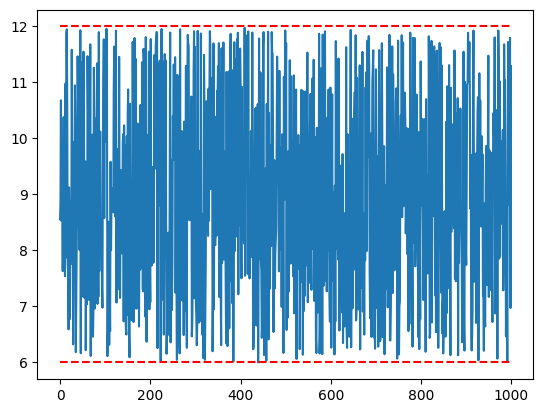

In [6]:
selected_bandit = 3
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((selected_bandit**2+selected_bandit)*np.ones(test_len), linestyle="--", color="r")
plt.plot((selected_bandit**2-selected_bandit)*np.ones(test_len), linestyle="--", color="r")

Then, we will test if the environment behaves correctly when an invalid action is given...

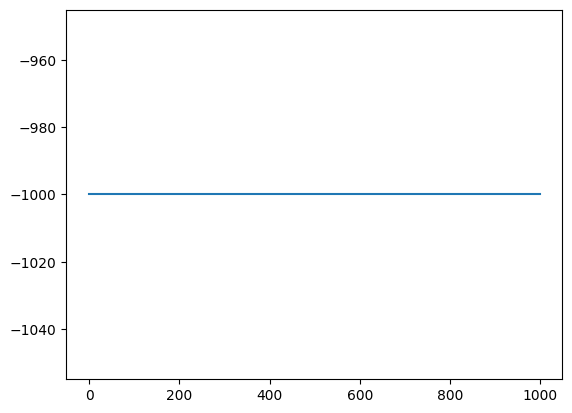

In [7]:
selected_bandit = -1
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")

Finally, let us check if the code runs with arbitrarily selected actions. This is quite tricky to do, since the whole system behaves stochastically. However, we know that the bandits are independent, and also that their mean values are 0, 1, 4, 9, and 16. Assuming each bandit is activated with the same probability, the mean value rewards obtained after many actions should be (0 + 1 + 4 + 9 + 16)/5 = 6.

In [8]:
test_rewards = [test_env.take_action(random.randint(0, 4)) for _ in range(test_len)]
test_mean = sum(test_rewards)/test_len

print("TEST MEAN = ", test_mean)

TEST MEAN =  6.042891521894894


## Decision Policies

In [9]:
def choose_greedy_action(q):
    return np.argmax(q)

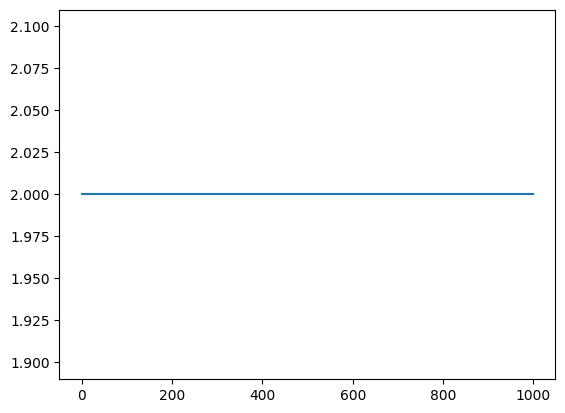

In [10]:
test_q = [1, 2, 3, 2, 1]

test_actions = [choose_greedy_action(test_q) for _ in range(test_len)]

plt.plot(test_actions)

In [11]:
def choose_random_action(n):
    return random.randint(0, n-1)

In [12]:
def choose_eps_greedy_action(q, eps):
    if random.random() > eps:
        return choose_greedy_action(q)
    else:
        return choose_random_action(len(q))

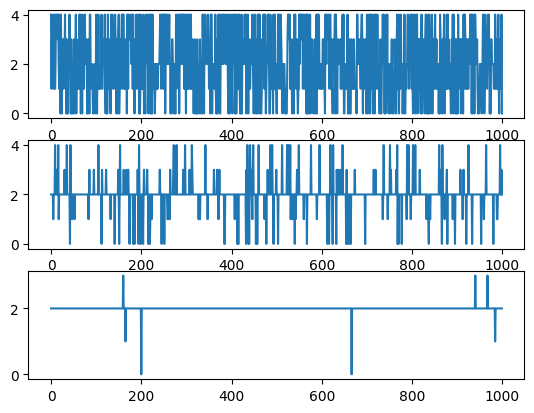

In [13]:
plt.subplot(3, 1, 1)
plt.plot([choose_eps_greedy_action(test_q, 1.0) for _ in range(test_len)])
plt.subplot(3, 1, 2)
plt.plot([choose_eps_greedy_action(test_q, 0.2) for _ in range(test_len)])
plt.subplot(3, 1, 3)
plt.plot([choose_eps_greedy_action(test_q, 0.01) for _ in range(test_len)])

## Training Loop

In [14]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
EPSILON = 0.1

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])
    
    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 217623.64it/s]


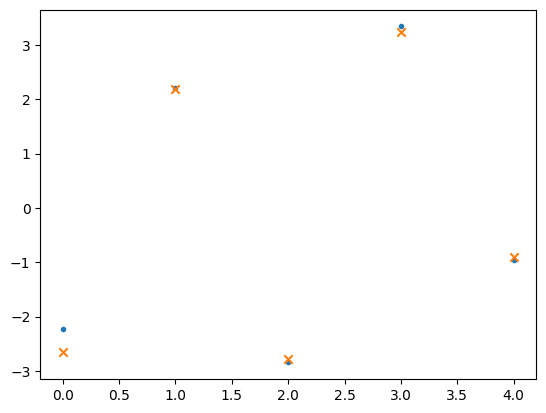

In [15]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

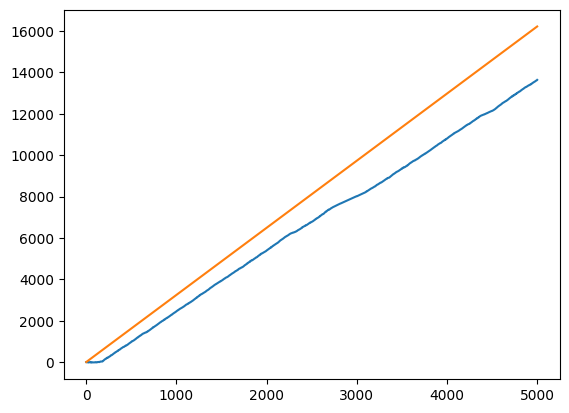

In [16]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

## Assignments for Individual Work

1. Experiment with the value of `epsilon`. Try smaller values, and verify that the slope difference is smaller. Verify also the oposite fact: increasing `epsilon` decreases the slope of the plotted achieved gain. Explain.
   
1. Perform a training run to learn the `q` vector (in essence, to estimate the mean value of the reward returned by each bandit). Create a test loop, in which the learned `q` values remain fixed. Compare performance of the agent to the ideal performance (as it is done in the previous point).

1. Plot the change of the estimated `q` values in time. Show that with passing time the algorithm sucessfully approximates mean rewards of all bandits.

1. Modify the environment so that the mean values of all bandits change in time. Repeat the training procedure. Evaluate its effectiveness.